In [1]:
import networkx as nx

from functions import *

In [2]:
from music21 import converter, environment

# Set the paths to MuseScore executable
env = environment.Environment()
env['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'  # Path to MuseScore executable
env['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'  # Path to MuseScore executable

## Functions Overview

### extract_score_elements
Extracts elements from a music21 score object and organizes them into a DataFrame.

### recreate_score
Recreates a music21 score object from a DataFrame of score elements.

### parse_score_elements
Parses a music21 score object into a DataFrame of note attributes and a list of note and chord elements.

### calculate_ir_symbol
Calculates the IR (Intervallic Relationship) symbol based on the intervals between notes.

### assign_ir_symbols
Assigns IR symbols and colors to each element in the score array.

### visualize_notes_with_symbols
Visualizes notes with their assigned IR symbols and colors in a music21 score.

### ir_symbols_to_matrix
Assigns IR symbols to the note matrix based on the note array.

### assign_ir_pattern_indices
Assigns pattern indices to the note matrix based on IR symbols.

### get_onset
Retrieves the onset times from the note matrix.

### get_duration
Retrieves the duration times from the note matrix.

### calculate_clang_boundaries
Calculates clang boundaries based on note matrix attributes.

### calculate_segment_boundaries
Calculates segment boundaries based on clang boundaries and note attributes.

### adjust_segment_boundaries
Adjusts segment boundaries to ensure IR patterns are not split.

### segmentgestalt
Segments the note matrix into meaningful groups based on IR patterns and boundaries.

### segments_to_distance_matrix
Converts segments to a distance matrix using multiprocessing.

### segments_to_graph
Converts segments to a k-NN graph and ensures connectivity.


# Usage
Current flow: \
converter.parse() output -> parse_score_elements() -> assign_ir_symbols -> ir_symbols_to_matrix -> assign_ir_pattern_indices -> segmentgestalt

In [3]:
# midi_file = '..\\bach_846.mid' # Hardcoded, for multiple songs, make a function to iterate thru folder
midi_file = "..\\Music Database\\GTTM Database\\Alexander Porfir’evich Borodin\\Quartet for 2 Violins, Viola and Violoncello D major 3 Nocturne.xml"
# midi_file = "..\\Music Database\\GTTM Database\\Georg Friedrich Händel\\Judas Maccabaeus HWV63 See the conquering hero comes.xml"
# midi_file = ".\\Music Database\\bach_cello_suites\\Suite No. 1 in G major\\cs1-1pre.mid"
midi_parsed = converter.parse(midi_file)

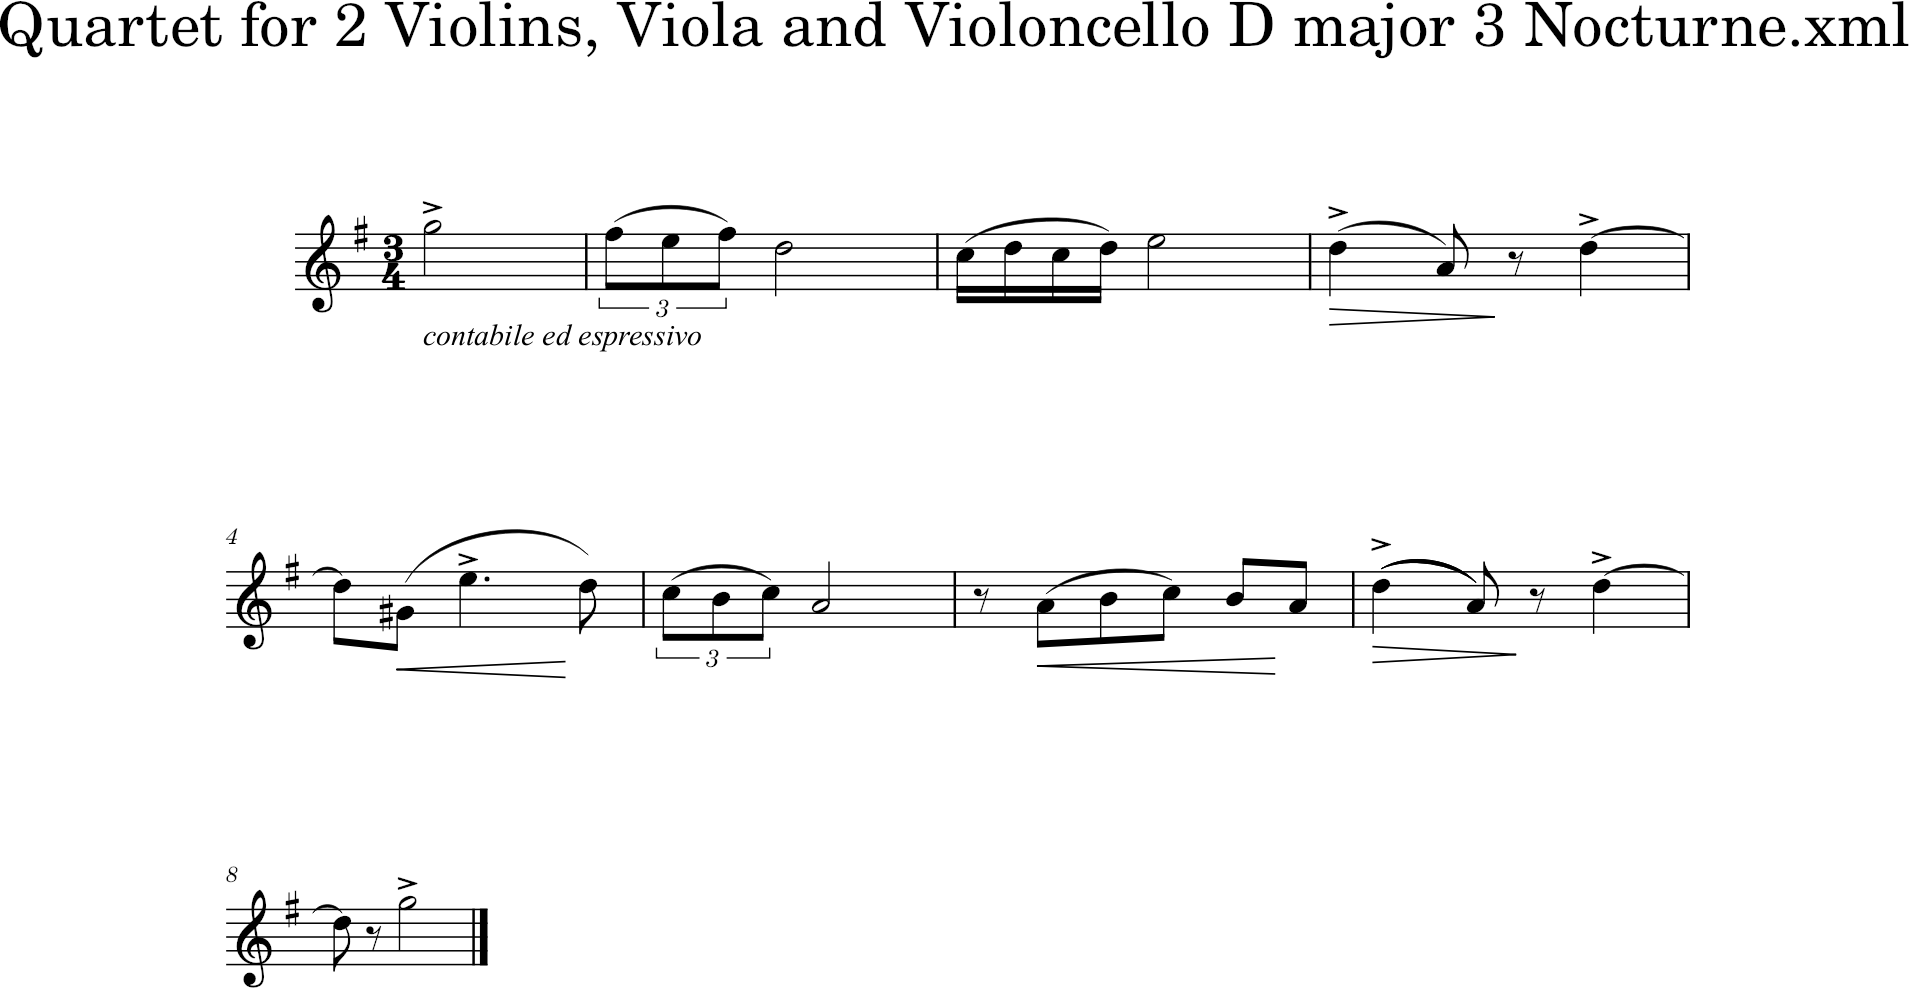

In [4]:
midi_parsed.show()

In [5]:
nmat, narr, sarr = parse_score_elements(midi_parsed)

In [6]:
ir_symbols = assign_ir_symbols(narr)

In [7]:
ir_nmat = ir_symbols_to_matrix(ir_symbols, nmat)

In [8]:
ir_nmat = assign_ir_pattern_indices(ir_nmat)

In [9]:
segments = segmentgestalt(ir_nmat)

In [10]:
processed_segments = preprocess_segments(segments)

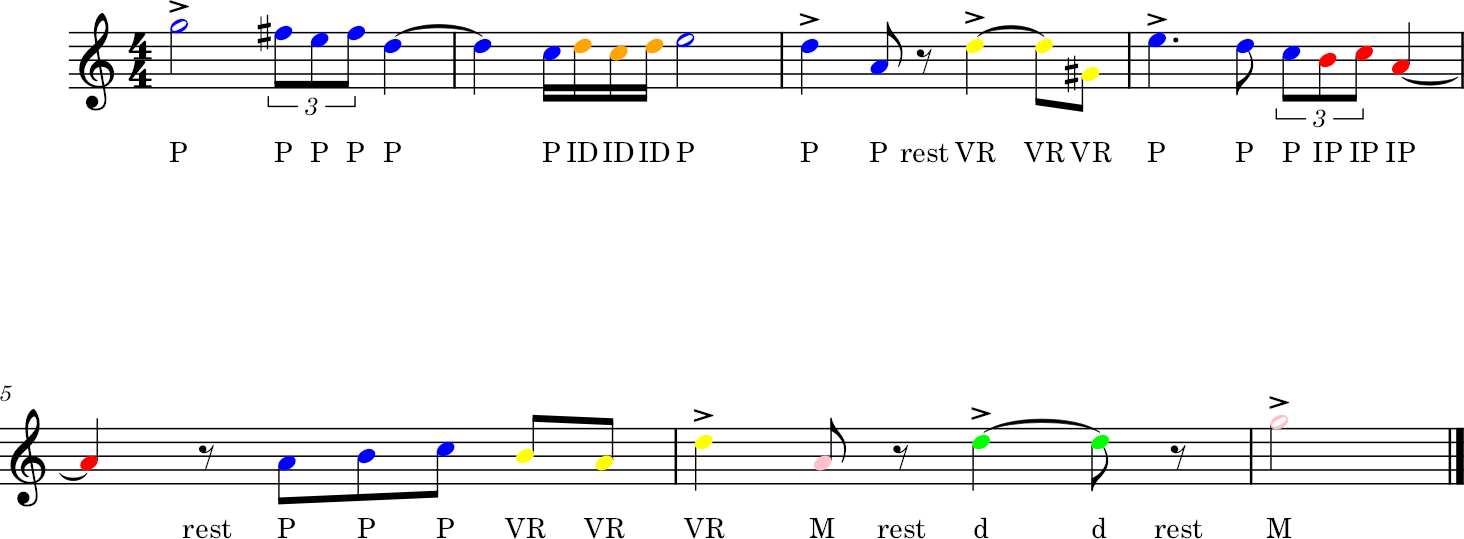

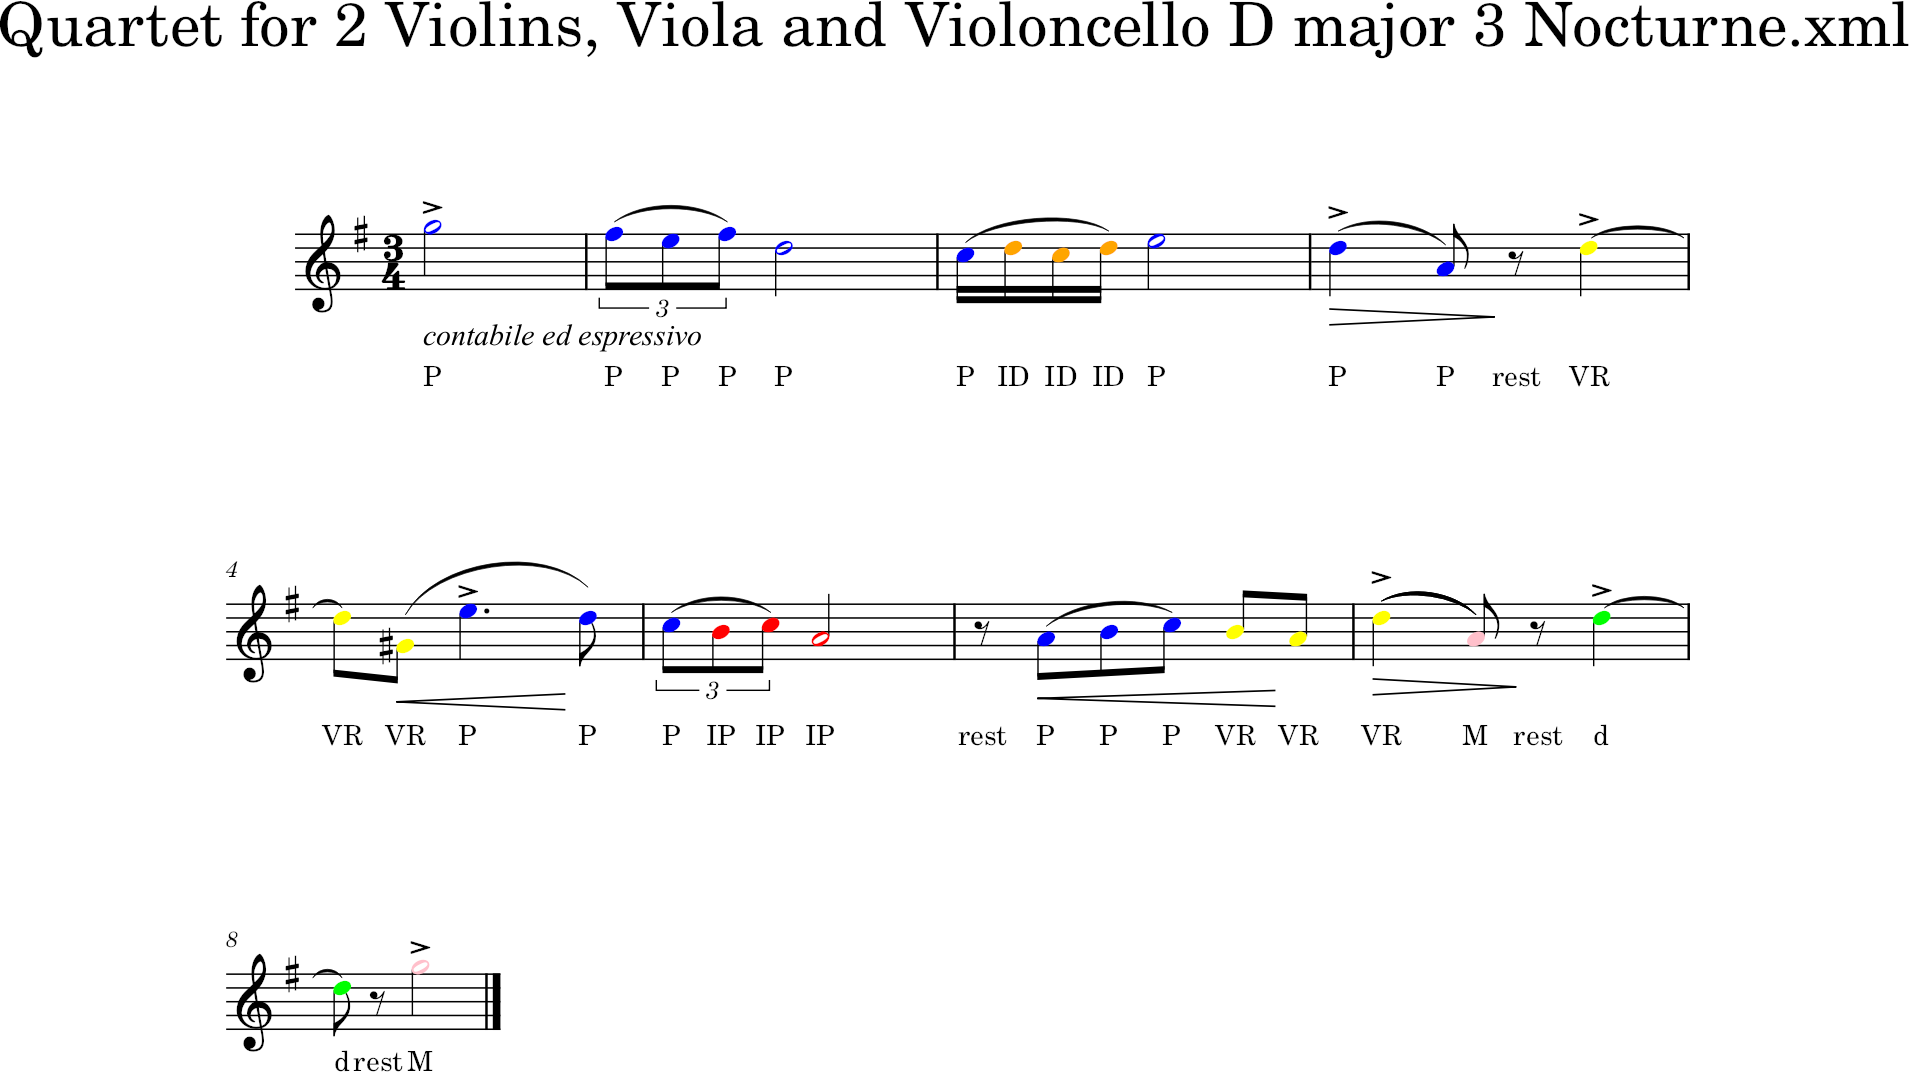

In [11]:
visualize_notes_with_symbols(ir_symbols)
midi_parsed.show()


In [12]:
processed_segments

[   onset_beats duration_beats  midi_pitch  ir_symbol_P  ir_symbol_D  \
 0          0.0            2.0        79.0            1            0   
 1          2.0            1/3        78.0            1            0   
 2          7/3            1/3        76.0            1            0   
 3          8/3            1/3        78.0            1            0   
 4          3.0            2.0        74.0            1            0   
 5          5.0           0.25        72.0            1            0   
 6         5.25           0.25        74.0            0            0   
 7          5.5           0.25        72.0            0            0   
 8         5.75           0.25        74.0            0            0   
 9          6.0            2.0        76.0            1            0   
 10         8.0            1.0        74.0            1            0   
 11         9.0            0.5        69.0            1            0   
 12         9.5            0.5         0.0            0         

In [13]:
def segments_to_distance_matrix(segments: list[pd.DataFrame], cores=None):
    if __name__ == '__main__':
        
        if cores is not None and cores > cpu_count():
            raise ValueError(f"You don't have enough cores! Please specify a value within your system's number of cores. \n Core Count: {cpu_count()}")
        
        seg_np = [segment.to_numpy() for segment in segments]
    
        num_segments = len(seg_np)
        distance_matrix = np.zeros((num_segments, num_segments))
    
        # Create argument list for multiprocessing
        args_list = []
        for i in range(num_segments):
            for j in range(i + 1, num_segments):
                args_list.append((i, j, segments[i], segments[j]))
    
        with Manager() as manager:
            message_list = manager.list()
    
            def log_message(message):
                message_list.append(message)
    
            # Use multiprocessing Pool to parallelize the calculations
            with Pool() as pool:
                results = pool.map(worker.calculate_distance, args_list)
    
            # Update distance matrix with the results
            for i, j, distance, message in results:
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance  # Reflect along the diagonal
                log_message(message)
    
            # Print messages from the shared list
            for message in message_list:
                print(message)
    
        return distance_matrix

In [14]:
distance_matrix = segments_to_distance_matrix(processed_segments)

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (1, 2)


In [15]:
type(processed_segments)

list

In [16]:
# distance matrix to knn graph function
def distance_matrix_to_knn_graph(k: int, distance_matrix: np.array, graph_title: str,
                                 seed: int, iterations: int):
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  G = nx.from_scipy_sparse_array(knn_graph)

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  # Plot the final connected graph
  pos = nx.spring_layout(G, seed=seed, iterations=iterations)
  nx.draw(G, node_size=50, pos=pos)
  plt.title(graph_title + f" (K={k})")
  plt.show()

In [19]:
# distance matrix to knn graph function
def distance_matrices_to_knn_graph(k: int, distance_matrix: np.array, graph_title: str,
                                 seed: int, iterations: int):
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  G = nx.from_scipy_sparse_array(knn_graph)

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  # Plot the final connected graph
  pos = nx.spring_layout(G, seed=seed, iterations=iterations)
  nx.draw(G, node_size=50, pos=pos)
  plt.title(graph_title + f" (K={k})")
  plt.show()

In [20]:
# show graph
distance_matrix_to_knn_graph(3, distance_matrix, "Bach Prelude in C", 9, 70)

ValueError: Expected n_neighbors < n_samples_fit, but n_neighbors = 3, n_samples_fit = 3, n_samples = 3

In [22]:
# segments to graph function
def segments_to_graph(k: int, segments: list[pd.DataFrame], labeled_segments, cores=None):
  # Convert segments to a distance matrix
  distance_matrix = segments_to_distance_matrix(segments, cores=cores)

  # Compute the k-NN graph
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  # Convert the k-NN graph to a NetworkX graph
  G = nx.from_scipy_sparse_array(knn_graph)

  # Add segment data as attributes to each node
  for i in range(len(segments)):
    G.nodes[i]['segment'] = labeled_segments[i] # print shit

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  return G, distance_matrix

In [ ]:
# segments to graph
graph, distance_matrix = segments_to_graph(5, segments, labeled_segments)

# Mass production

In [23]:
import os

In [24]:
# Find all composers with more than 3 songs in the database
def get_directories_with_min_files(root_dir, min_file_count=5):
    qualifying_directories = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count the number of files in the current directory
        file_count = len([name for name in filenames if os.path.isfile(os.path.join(dirpath, name))])

        # Check if the current directory has at least min_file_count files
        if file_count > min_file_count:
            qualifying_directories.append(os.path.basename(dirpath))

    return qualifying_directories

In [25]:
root_directory = '../Music Database/GTTM Database' 
directories = get_directories_with_min_files(root_directory, 10)

In [26]:
directories.remove("Louis A. Saint-Jacome")
directories

['Franz Peter Schubert',
 'Frédéric Françoiss Chopin',
 'Ludwig van Beethoven',
 'Pyotr Il’yich Tchaikovsky',
 'Wolfgang Amadeus Mozart']

In [27]:
# Original Code Bolck
composer_segments = dict.fromkeys(directories, None)                # Composer matrix that is the average of piece matrices
labeled_composer_segments = dict.fromkeys(directories, None)

for composer in composer_segments:
    filepath = "../Music Database/GTTM Database/" + composer
    labeled_segments = []
    processed_segments = []
    
    piece_count = 0
    for piece in os.listdir(filepath):
        piece_path = os.path.join(filepath, piece)
        parsed_score = converter.parse(piece_path)
        nmat, narr, sarr = parse_score_elements(parsed_score)
        ir_symbols = assign_ir_symbols(narr)
        ir_nmat = ir_symbols_to_matrix(ir_symbols, nmat)
        ir_nmat = assign_ir_pattern_indices(ir_nmat)
        segments = segmentgestalt(ir_nmat)
        processed_segments.extend(preprocess_segments(segments))
        piece_count += 1
        
    labeled_segments.extend([(piece[:-4], segment) for segment in processed_segments]) # turned into one line instead of a function
    
    print(f'Composer: {composer} | Piece Count: {piece_count} \n Processed Segments: {len(processed_segments)}')


    composer_segments[composer] = processed_segments
    labeled_composer_segments[composer] = labeled_segments

Composer: Franz Peter Schubert | Piece Count: 15 
 Processed Segments: 37
Composer: Frédéric Françoiss Chopin | Piece Count: 21 
 Processed Segments: 74
Composer: Ludwig van Beethoven | Piece Count: 30 
 Processed Segments: 85
Composer: Pyotr Il’yich Tchaikovsky | Piece Count: 15 
 Processed Segments: 46
Composer: Wolfgang Amadeus Mozart | Piece Count: 15 
 Processed Segments: 52


In [28]:
composer_dist_mats = dict.fromkeys(directories, None)

for composer, segments in composer_segments.items():
    composer_dist_mats[composer] = segments_to_distance_matrix(segments)

print(len(composer_dist_mats[composer]))
print(composer_dist_mats[composer])

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (0, 3)
Calculated Edge Weight (0, 4)
Calculated Edge Weight (0, 5)
Calculated Edge Weight (0, 6)
Calculated Edge Weight (0, 7)
Calculated Edge Weight (0, 8)
Calculated Edge Weight (0, 9)
Calculated Edge Weight (0, 10)
Calculated Edge Weight (0, 11)
Calculated Edge Weight (0, 12)
Calculated Edge Weight (0, 13)
Calculated Edge Weight (0, 14)
Calculated Edge Weight (0, 15)
Calculated Edge Weight (0, 16)
Calculated Edge Weight (0, 17)
Calculated Edge Weight (0, 18)
Calculated Edge Weight (0, 19)
Calculated Edge Weight (0, 20)
Calculated Edge Weight (0, 21)
Calculated Edge Weight (0, 22)
Calculated Edge Weight (0, 23)
Calculated Edge Weight (0, 24)
Calculated Edge Weight (0, 25)
Calculated Edge Weight (0, 26)
Calculated Edge Weight (0, 27)
Calculated Edge Weight (0, 28)
Calculated Edge Weight (0, 29)
Calculated Edge Weight (0, 30)
Calculated Edge Weight (0, 31)
Calculated Edge Weight (0, 32)
Calculated Edge W

In [29]:
def composers_segments_to_graphs(k: int, composers_segments: dict, seed: int, iterations: int, cores=None):
    """
    Creates KNN graphs from segments and plots them in a grid layout.

    Parameters:
    k (int): Number of nearest neighbors for the KNN graph.
    composers_segments (dict): Dictionary where keys are composer names and values are their segments.
    seed (int): Random seed for the spring layout.
    iterations (int): Number of iterations for the spring layout.
    cores (int, optional): Number of CPU cores to use for parallel processing.
    """
    num_graphs = len(composers_segments)
    rows_needed = (num_graphs + 1) // 2  # Calculate rows needed for two columns
    fig, axes = plt.subplots(rows_needed, 2, figsize=(12, rows_needed * 5))  # 2 columns, rows as needed

    if num_graphs == 1:
        axes = np.array([[axes]])  # Ensure axes is 2D array for single graph
    elif num_graphs == 2:
        axes = axes.reshape(-1, 2)  # Reshape to ensure 2 columns when exactly two graphs

    axes = axes.flatten()  # Flatten the axes array to iterate easily
    for ax, (composer, segments) in zip(axes, composers_segments.items()):
        # labeled_segments = [f"Segment {i}" for i in range(len(segments))]
        G, distance_matrix = segments_to_graph(k, segments, labeled_segments, cores=cores)

        # Plot the final connected graph
        pos = nx.spring_layout(G, seed=seed, iterations=iterations)
        nx.draw(G, node_size=50, pos=pos, ax=ax)
        ax.set_title(f"{composer} (K={k})")
        ax.axis('off')

    # Hide any unused axes if there are fewer graphs than subplots
    for ax in axes[num_graphs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [30]:
composer_graphs = dict.fromkeys(directories, None)

def distance_matrices_to_knn_graphs(k: int, distance_matrices: dict, seed: int, iterations: int):
    """
    Creates KNN graphs from distance matrices and plots them in a grid layout.

    Parameters:
    k (int): Number of nearest neighbors for the KNN graph.
    distance_matrices (dict): Dictionary where keys are composer names and values are distance matrices.
    seed (int): Random seed for the spring layout.
    iterations (int): Number of iterations for the spring layout.
    """
    num_graphs = len(distance_matrices)
    rows_needed = (num_graphs + 1) // 2  # Calculate rows needed for two columns
    fig, axes = plt.subplots(rows_needed, 2, figsize=(12, rows_needed * 5))  # 2 columns, rows as needed

    if num_graphs == 1:
        axes = np.array([[axes]])  # Ensure axes is 2D array for single graph
    elif num_graphs == 2:
        axes = axes.reshape(-1, 2)  # Reshape to ensure 2 columns when exactly two graphs

    axes = axes.flatten()  # Flatten the axes array to iterate easily
    for ax, (composer, distance_matrix) in zip(axes, distance_matrices.items()):
        knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')
        G = nx.from_scipy_sparse_array(knn_graph)

        # Detect if the graph is disjoint
        if not nx.is_connected(G):
            print(f"The KNN graph for {composer} is disjoint. Ensuring connectivity...")

            # Calculate the connected components
            components = list(nx.connected_components(G))

            # Connect the components
            for i in range(len(components) - 1):
                min_dist = np.inf
                closest_pair = None
                for node1 in components[i]:
                    for node2 in components[i + 1]:
                        dist = distance_matrix[node1, node2]
                        if dist < min_dist:
                            min_dist = dist
                            closest_pair = (node1, node2)

                # Add an edge between the closest pair of nodes from different components
                G.add_edge(closest_pair[0], closest_pair[1])
            
        composer_graphs[composer] = G

        # Plot the final connected graph
        pos = nx.spring_layout(G, seed=seed, iterations=iterations)
        nx.draw(G, node_size=50, pos=pos, ax=ax)
        ax.set_title(f"{composer} (K={k})")
        ax.axis('off')

    # Hide any unused axes if there are fewer graphs than subplots
    for ax in axes[num_graphs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


The KNN graph for Franz Peter Schubert is disjoint. Ensuring connectivity...
The KNN graph for Pyotr Il’yich Tchaikovsky is disjoint. Ensuring connectivity...


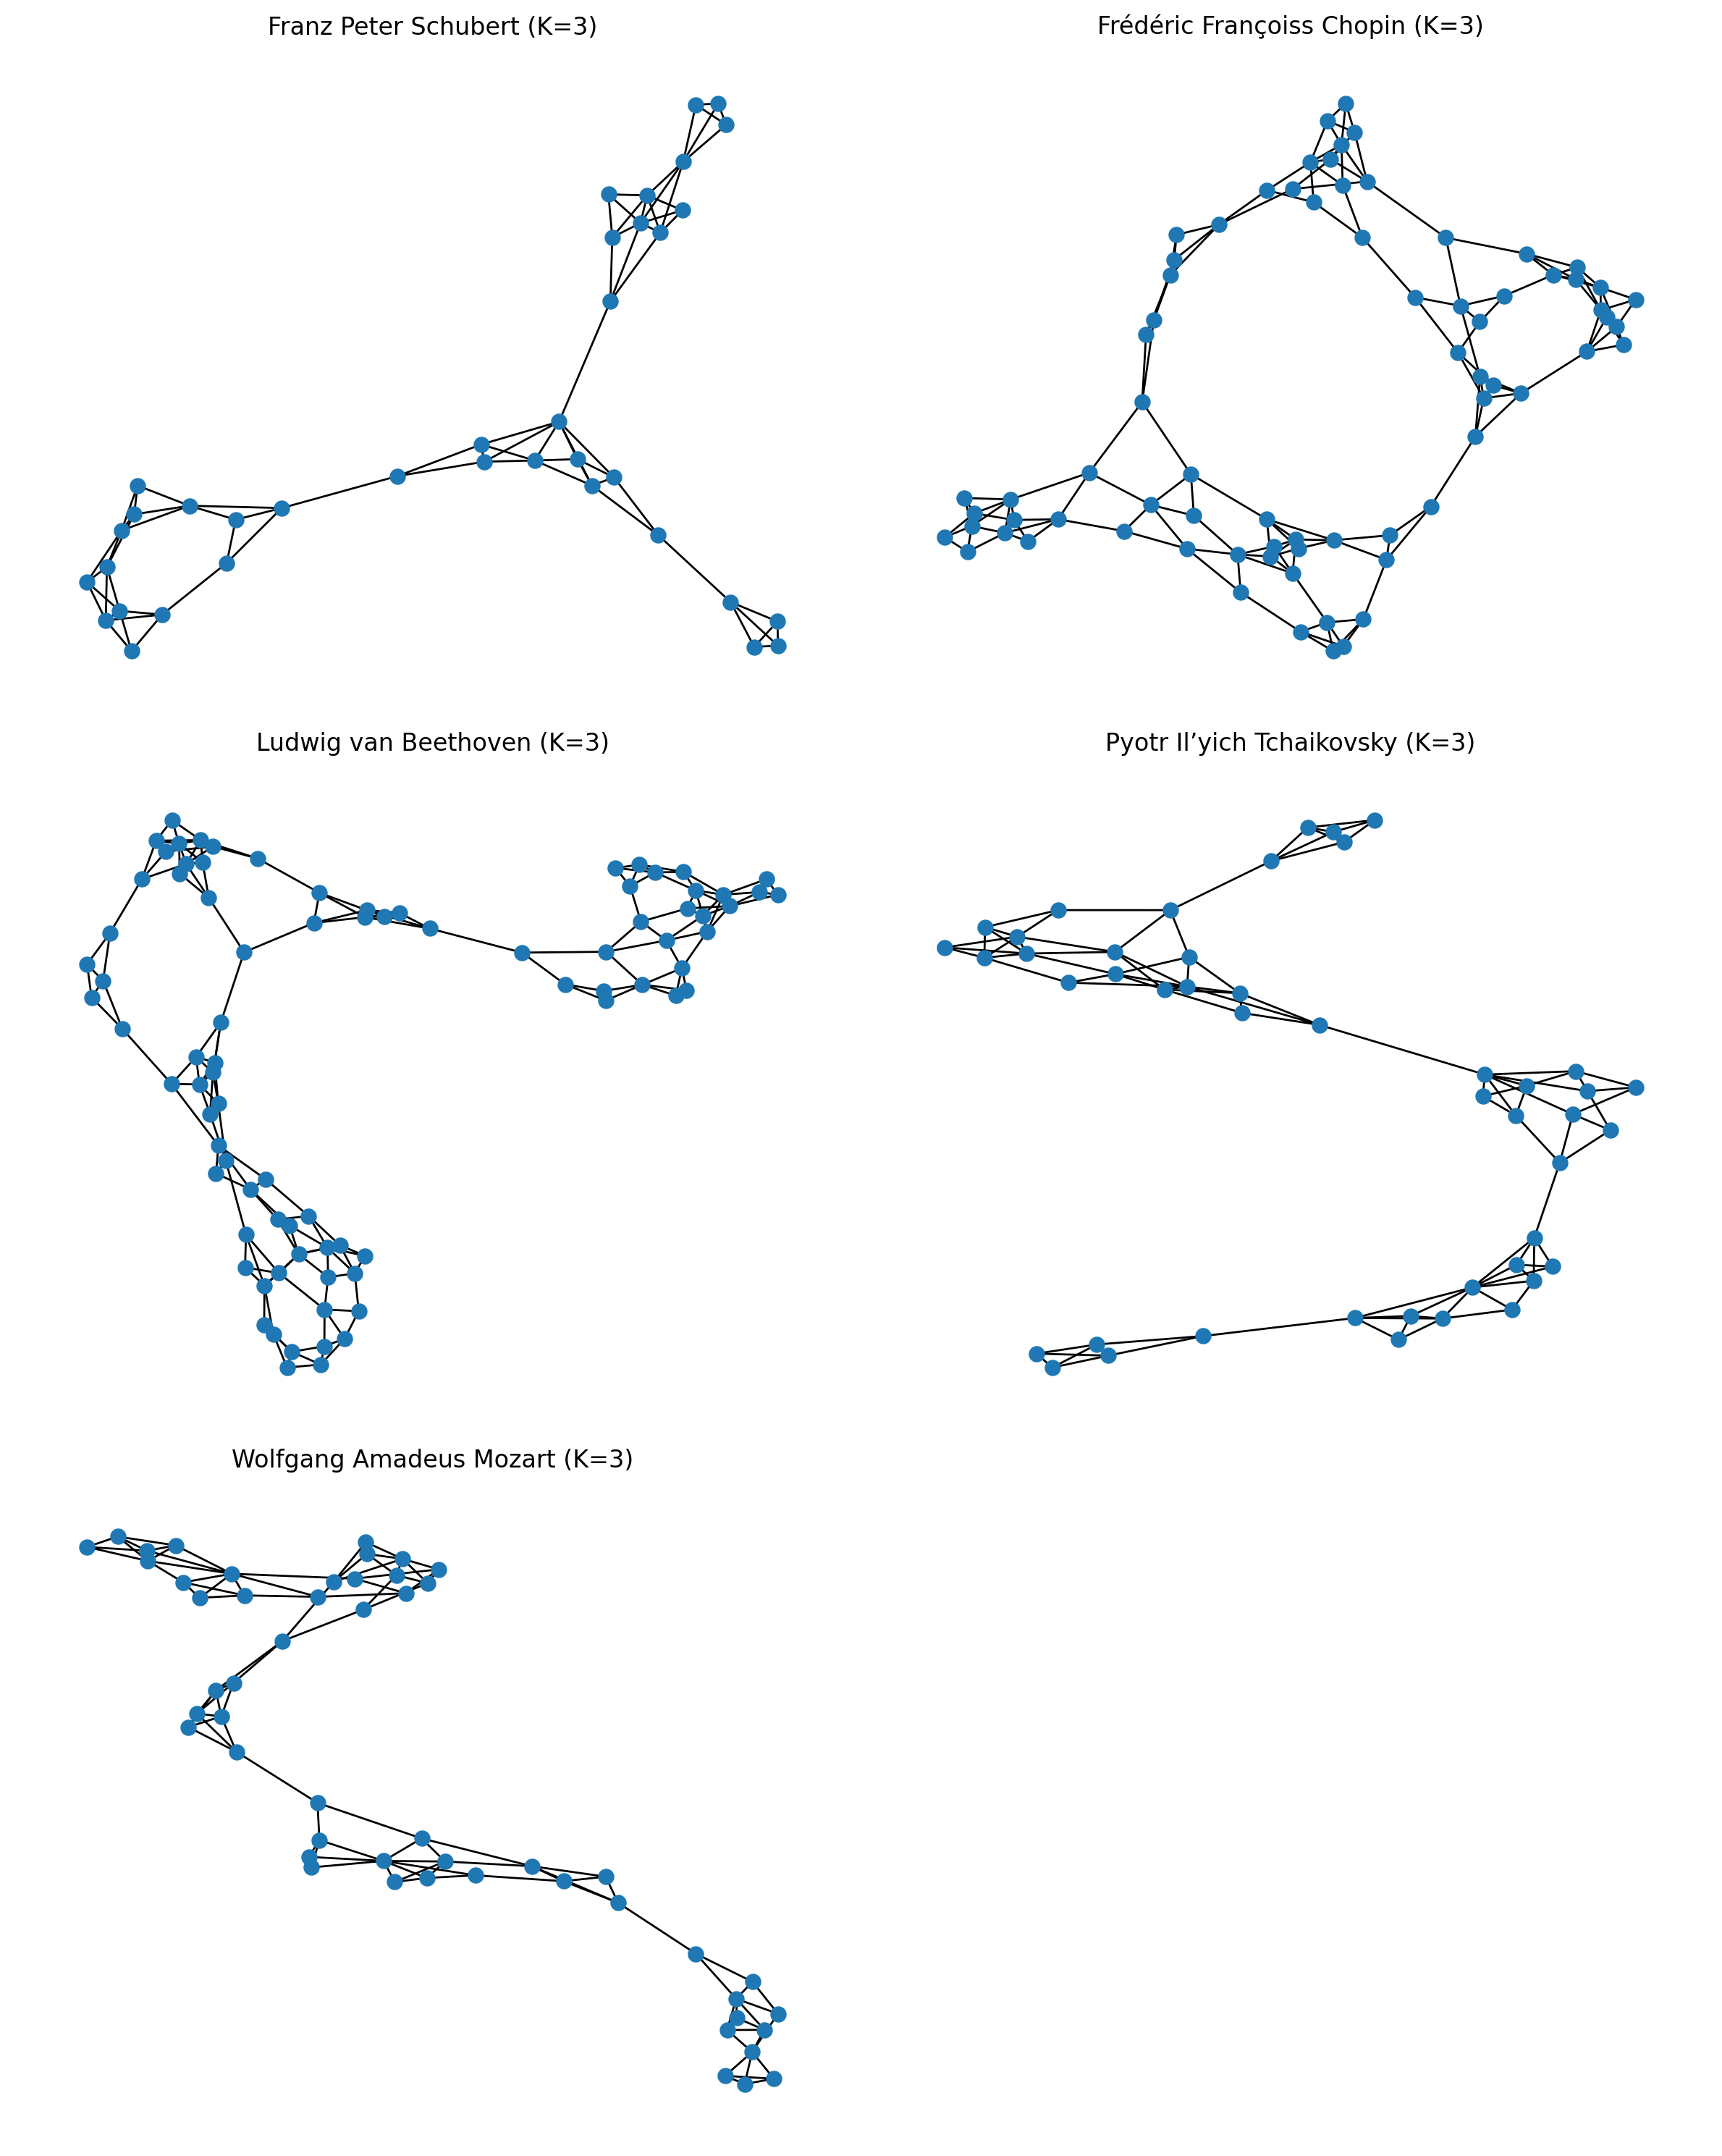

In [31]:
distance_matrices_to_knn_graphs(3, composer_dist_mats, seed=69, iterations=65)

In [32]:
def graph_metrics(graph: nx.classes.graph.Graph, distance_matrix: np.array, seed: int) -> pd.DataFrame:
    """
    Calculates various graph metrics and returns them in a DataFrame.

    Parameters:
    graph (nx.classes.graph.Graph): The graph to analyze.
    distance_matrix (np.array): The distance matrix.
    seed (int): Random seed for community detection.

    Returns:
    pd.DataFrame: DataFrame containing the average metrics.
    """
    avg_dtw_distance = distance_matrix.mean()
    avg_clustering_coef = nx.average_clustering(graph)

    communities = nx.community.louvain_communities(graph, seed=seed)

    silhouette_scores = []
    for cluster in communities:
        for i in cluster:
            cluster_distances = distance_matrix[i, list(cluster - {i})]
            homogeneity = np.mean(cluster_distances)
            other_cluster_distances = [np.mean(distance_matrix[i, list(other_cluster)]) for other_cluster in communities if other_cluster != cluster]
            heterogeneity = min(other_cluster_distances) if other_cluster_distances else homogeneity
            silhouette_score = (heterogeneity - homogeneity) / max(heterogeneity, homogeneity)
            silhouette_scores.append(silhouette_score)

    # Average silhouette score for all nodes
    average_silhouette_score = np.mean(silhouette_scores)

    conductance_scores = []
    for cluster in communities:
        cluster_conductance = conductance(graph, cluster)
        conductance_scores.append(cluster_conductance)

    average_conductance = np.mean(conductance_scores)
    
    modularity = nx.algorithms.community.modularity(graph, communities)

    # Create a dictionary to hold the metrics
    metrics_dict = {
        'Metric': ['Average DTW Distance', 'Average Clustering Coefficient', 'Average Silhouette Score', 'Average Conductance', 'Modularity'],
        'Value': [avg_dtw_distance, avg_clustering_coef, average_silhouette_score, average_conductance, modularity]
    }

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame(metrics_dict)

    return metrics_df

In [33]:
composer_metrics = dict.fromkeys(directories, None)

In [34]:
composer_graphs

{'Franz Peter Schubert': <networkx.classes.graph.Graph at 0x16c799981d0>,
 'Frédéric Françoiss Chopin': <networkx.classes.graph.Graph at 0x16c79a62890>,
 'Ludwig van Beethoven': <networkx.classes.graph.Graph at 0x16c7980d350>,
 'Pyotr Il’yich Tchaikovsky': <networkx.classes.graph.Graph at 0x16c799bdd50>,
 'Wolfgang Amadeus Mozart': <networkx.classes.graph.Graph at 0x16c79a5e210>}

In [35]:
for composer in directories:
    composer_metrics[composer] = graph_metrics(composer_graphs[composer], composer_dist_mats[composer], 42)

In [36]:
composer_metrics["Franz Peter Schubert"]

,Metric,Value
0,Average DTW Distance,85.391689
1,Average Clustering Coefficient,0.658301
2,Average Silhouette Score,0.242017
3,Average Conductance,0.136313
4,Modularity,0.680402


In [37]:
for composer, metrics in composer_metrics.items():
    print(f'Composer {composer}\n{metrics}\n')

Composer Franz Peter Schubert
                           Metric      Value
0            Average DTW Distance  85.391689
1  Average Clustering Coefficient   0.658301
2        Average Silhouette Score   0.242017
3             Average Conductance   0.136313
4                      Modularity   0.680402

Composer Frédéric Françoiss Chopin
                           Metric       Value
0            Average DTW Distance  104.095487
1  Average Clustering Coefficient    0.439640
2        Average Silhouette Score    0.169359
3             Average Conductance    0.135011
4                      Modularity    0.724427

Composer Ludwig van Beethoven
                           Metric       Value
0            Average DTW Distance  107.578692
1  Average Clustering Coefficient    0.479104
2        Average Silhouette Score    0.270562
3             Average Conductance    0.104589
4                      Modularity    0.763132

Composer Pyotr Il’yich Tchaikovsky
                           Metric       Value